In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

# Load data
df = pd.read_csv("../data/raw/crypto_hourly_data.csv")

# Convert datetime
if 'timestamp' in df.columns:
    df['datetime'] = pd.to_datetime(df['timestamp'])
elif 'date' in df.columns and 'time' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
else:
    raise ValueError("Không tìm thấy timestamp hoặc date/time")

df = df.sort_values('datetime')
df = df.set_index('datetime')

# Fix duplicated datetime
df = df[~df.index.duplicated(keep='first')]

# Convert numeric columns
num_cols = ['open','high','low','close','volume','quote_volume',
            'taker_buy_base_volume','taker_buy_quote_volume']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.head()


,open,high,low,close,volume,quote_volume,trades_count,taker_buy_base_volume,taker_buy_quote_volume,timestamp,date,time,symbol,interval
datetime,,,,,,,,,,,,,,
2025-10-21 23:00:00,109066.9800,109423.1900,108045.8100,108297.6700,1.531007e+03,1.664970e+08,301894,6.009483e+02,6.533803e+07,2025-10-21 23:00:00,2025-10-21,23:00:00,BTCUSDT,1h
2025-10-22 00:00:00,92.4500,92.8800,91.9500,92.3900,4.082702e+04,3.773372e+06,23205,1.538559e+04,1.421858e+06,2025-10-22 00:00:00,2025-10-22,00:00:00,LTCUSDT,1h
2025-10-22 01:00:00,4080.0700,4122.4800,4067.7300,4089.6200,1.333119e+03,5.468886e+06,19128,6.276702e+02,2.574937e+06,2025-10-22 01:00:00,2025-10-22,01:00:00,PAXGUSDT,1h
2025-10-22 02:00:00,2.4247,2.4326,2.4215,2.4236,2.912694e+06,7.066564e+06,28501,1.727951e+06,4.192300e+06,2025-10-22 02:00:00,2025-10-22,02:00:00,XRPUSDT,1h
2025-10-22 03:00:00,2.4236,2.4237,2.4088,2.4201,3.881306e+06,9.376644e+06,32162,1.953708e+06,4.720081e+06,2025-10-22 03:00:00,2025-10-22,03:00:00,XRPUSDT,1h


## Câu hỏi 1 – Volume có ảnh hưởng đến biến động giá không?

**Ý nghĩa:**  
Volume là một trong những yếu tố quan trọng nhất trong thị trường crypto.  
Khi **volume tăng**, giá thường có xu hướng **biến động mạnh hơn**.  
Hiểu được mối quan hệ này giúp đánh giá độ rủi ro và cải thiện mô hình dự đoán giá.

Correlation giữa Volume và Biến động giá: -0.006057451284738871


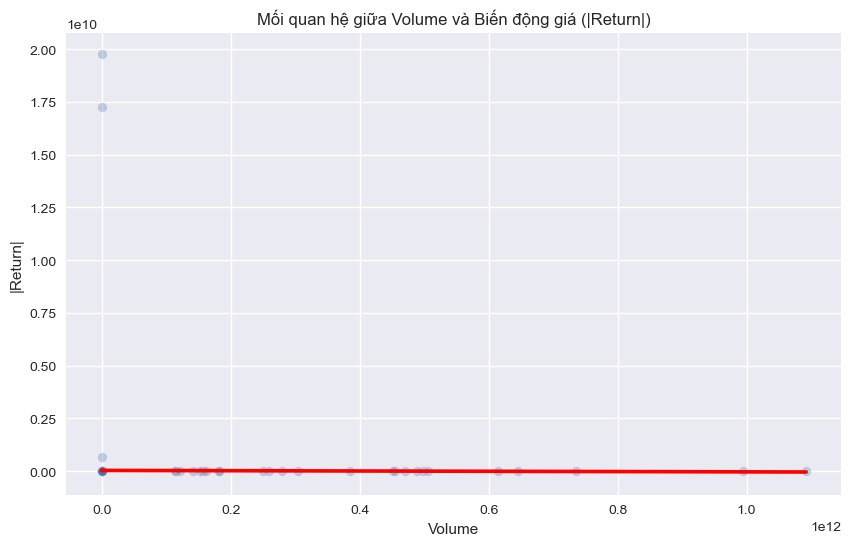

In [27]:
# Tính price return
df['return'] = df['close'].pct_change()
df['abs_return'] = df['return'].abs()

# Correlation
corr_q1 = df[['volume', 'abs_return']].corr().iloc[0,1]
print("Correlation giữa Volume và Biến động giá:", corr_q1)

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='volume', y='abs_return', alpha=0.3)
sns.regplot(data=df, x='volume', y='abs_return', scatter=False, color='red')

plt.title("Mối quan hệ giữa Volume và Biến động giá (|Return|)")
plt.xlabel("Volume")
plt.ylabel("|Return|")
plt.show()


## Câu hỏi 2 – Taker Buy Volume có dự báo xu hướng giá không?

**Ý nghĩa:**  
Taker Buy Volume thể hiện lực mua chủ động.  
Nếu chỉ số này tăng mạnh, thị trường có thể đang chuyển sang xu hướng **bullish**.  
Phân tích mối quan hệ này giúp nhận diện tín hiệu dòng tiền và momentum thị trường.

Correlation giữa Taker Buy Quote Volume và Price Return: 0.027022229435016313


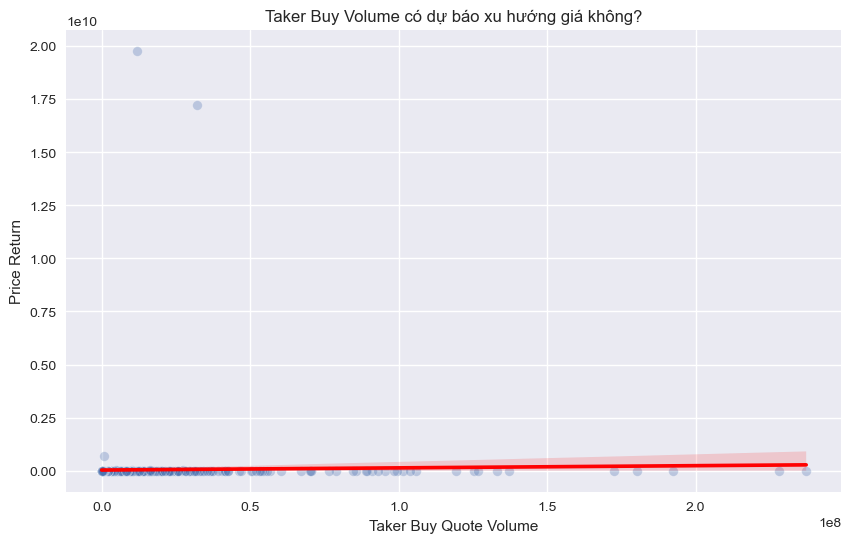

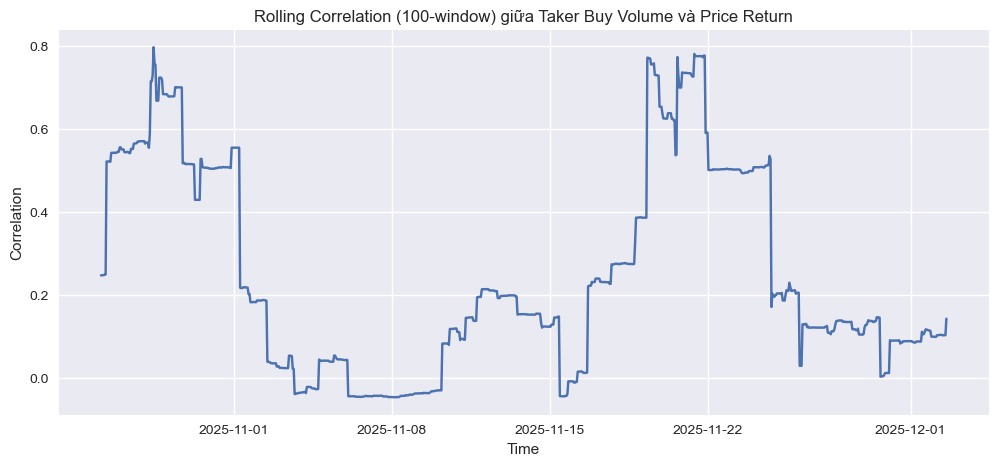

In [28]:
# Tính price return cho xu hướng giá
df['price_return'] = df['close'].pct_change()

# Correlation
corr_q2 = df[['taker_buy_quote_volume', 'price_return']].corr().iloc[0,1]
print("Correlation giữa Taker Buy Quote Volume và Price Return:", corr_q2)

# Plot scatter
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='taker_buy_quote_volume', y='price_return', alpha=0.3)
sns.regplot(data=df, x='taker_buy_quote_volume', y='price_return', scatter=False, color='red')

plt.title("Taker Buy Volume có dự báo xu hướng giá không?")
plt.xlabel("Taker Buy Quote Volume")
plt.ylabel("Price Return")
plt.show()

# Rolling correlation
df['rolling_corr'] = df['taker_buy_quote_volume'].rolling(100).corr(df['price_return'])

plt.figure(figsize=(12,5))
plt.plot(df['rolling_corr'])
plt.title("Rolling Correlation (100-window) giữa Taker Buy Volume và Price Return")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.show()


## Câu hỏi 3 – Hiệu suất theo khung giờ giao dịch (0h–23h)

**Ý nghĩa:**  
Giá và khối lượng giao dịch thay đổi theo từng giờ trong ngày.  
Việc tìm ra “**golden hour**” giúp xác định thời điểm thanh khoản mạnh hoặc biến động cao để tối ưu chiến lược giao dịch.


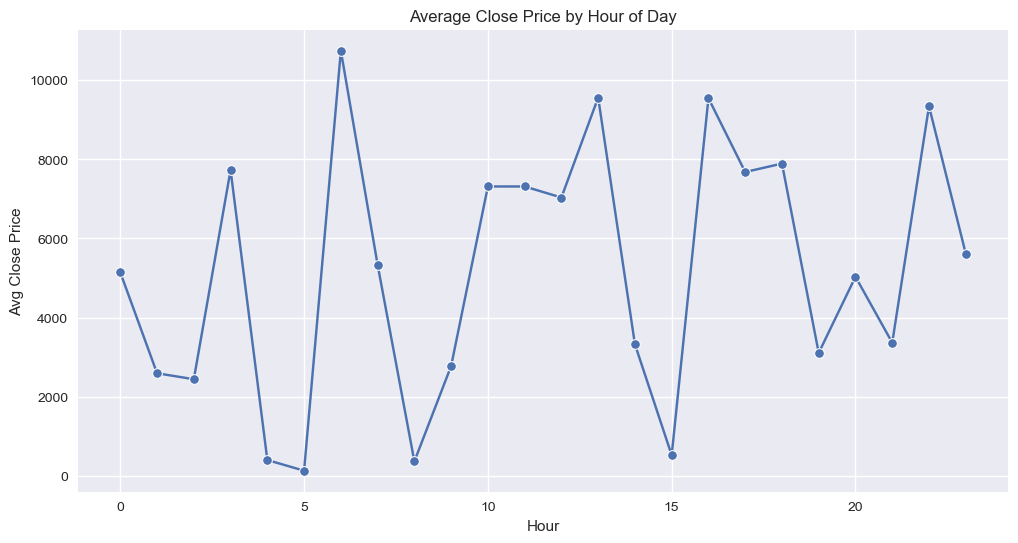

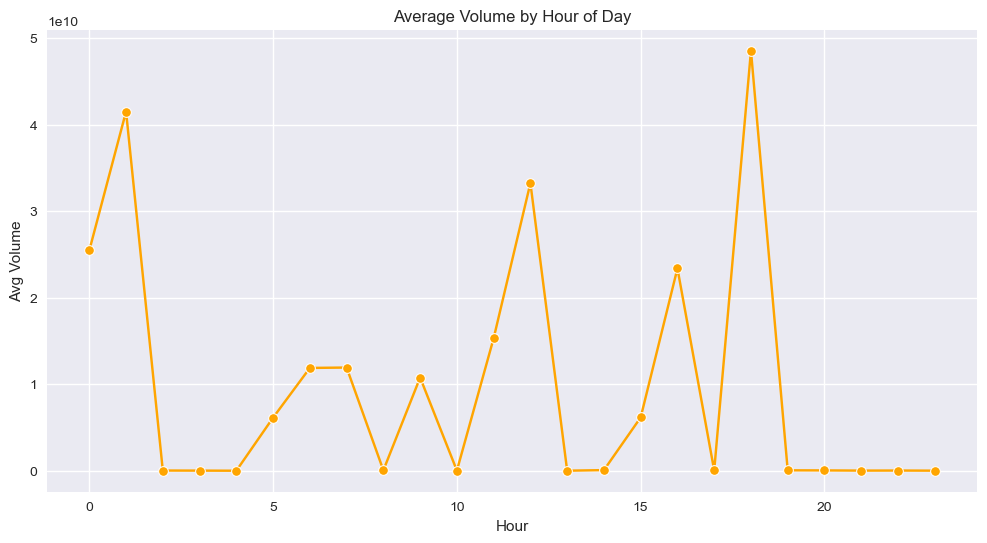

,hour,avg_close,avg_volume
0,0,5140.487535,2.546936e+10
1,1,2589.343036,4.153208e+10
2,2,2438.584356,2.540687e+07
3,3,7729.503397,1.528037e+07
4,4,394.782540,3.458627e+06
5,5,123.745588,6.140383e+09
6,6,10749.356719,1.188704e+10
7,7,5334.865333,1.193274e+10
8,8,359.539227,5.321674e+07
9,9,2772.137420,1.077328e+10


In [29]:
df["hour"] = df.index.hour

hour_stats = df.groupby("hour").agg(
    avg_close=("close", "mean"),
    avg_volume=("volume", "mean")
).reset_index()

fig, ax1 = plt.subplots(figsize=(12,6))
sns.lineplot(data=hour_stats, x="hour", y="avg_close", marker="o", ax=ax1)
ax1.set_title("Average Close Price by Hour of Day")
ax1.set_ylabel("Avg Close Price")
ax1.set_xlabel("Hour")
ax1.grid(True)
plt.show()

fig, ax2 = plt.subplots(figsize=(12,6))
sns.lineplot(data=hour_stats, x="hour", y="avg_volume", marker="o", color="orange")
ax2.set_title("Average Volume by Hour of Day")
ax2.set_ylabel("Avg Volume")
ax2.set_xlabel("Hour")
ax2.grid(True)
plt.show()

hour_stats


## Câu hỏi 4 – Chênh lệch giá (High–Low Spread) thay đổi như thế nào khi khối lượng giao dịch tăng?

**Ý nghĩa:**  
Thay vì nhìn *return*, việc phân tích biên độ giá trong mỗi giờ (khoảng cách giữa **High** và **Low**) giúp đánh giá mức độ “mở rộng” của thị trường.  
Khi **volume tăng cao**, biên độ **High–Low** thường **mở rộng**, phản ánh sự cạnh tranh mạnh giữa bên mua và bán. Điều này giúp xác định thời điểm thị trường dễ biến động mạnh và rủi ro cao hơn.



Correlation giữa Volume và High–Low Spread: -0.02657483405595572


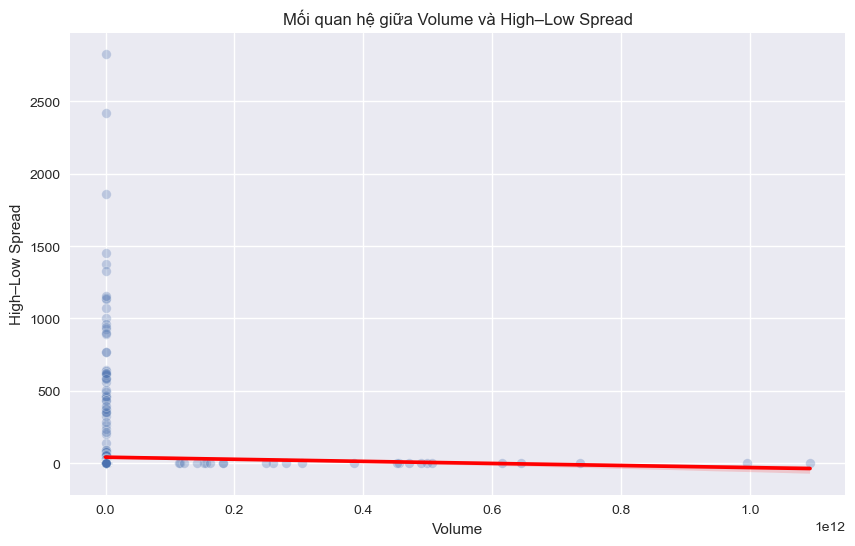


Spread trung bình theo nhóm volume:
volume_group
Thấp          151.586881
Trung bình      7.950000
Cao             0.042544
Rất cao         0.006805
Name: hl_spread, dtype: float64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18800\2044567318.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spread_stats = df.groupby("volume_group")["hl_spread"].mean()


In [ ]:
# Tính High–Low Spread theo mỗi candle
df["hl_spread"] = df["high"] - df["low"]

# Tính tương quan giữa volume và spread
corr_q4 = df[["volume", "hl_spread"]].corr().iloc[0,1]
print("Correlation giữa Volume và High–Low Spread:", corr_q4)

# Plot scatter + regression line
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="volume", y="hl_spread", alpha=0.3)
sns.regplot(data=df, x="volume", y="hl_spread", scatter=False, color="red")

plt.title("Mối quan hệ giữa Volume và High–Low Spread")
plt.xlabel("Volume")
plt.ylabel("High–Low Spread")
plt.grid(True)
plt.show()

# Bình quân spread theo nhóm volume (chia quantile để so sánh)
df["volume_group"] = pd.qcut(df["volume"], q=4, labels=["Thấp", "Trung bình", "Cao", "Rất cao"])
spread_stats = df.groupby("volume_group")["hl_spread"].mean()
print("\nSpread trung bình theo nhóm volume:")
print(spread_stats)